In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl

import matplotlib.pyplot as plt
from IPython.display import display
plt.style.use("fivethirtyeight")
sns.set_style({'font.sans-serif':['simhei','Arial']})
%matplotlib inline

In [24]:
df = pd.read_csv('../data/lianjia.csv')
# 移除结构类型异常值和房屋大小异常值
df = df[(df['Layout']!='叠拼别墅')&(df['Size']<1000)]

# 去掉错误数据“南北”，因为爬虫过程中一些信息位置为空，导致“Direction”的特征出现在这里，需要清除或替换
df['Renovation'] = df.loc[(df['Renovation'] != '南北'), 'Renovation']

# 由于存在个别类型错误，如简装和精装，特征值错位，故需要移除
df['Elevator'] = df.loc[(df['Elevator'] == '有电梯')|(df['Elevator'] == '无电梯'), 'Elevator']

# 填补Elevator缺失值
df.loc[(df['Floor']>6)&(df['Elevator'].isnull()), 'Elevator'] = '有电梯'
df.loc[(df['Floor']<=6)&(df['Elevator'].isnull()), 'Elevator'] = '无电梯'

# 只考虑“室”和“厅”，将其它少数“房间”和“卫”移除
df = df.loc[df['Layout'].str.extract('^\d(.*?)\d.*?',expand=False) == '室']

# 提取“室”和“厅”创建新特征
df['Layout_room_num'] = df['Layout'].str.extract('(^\d).*', expand=False).astype('int64')
df['Layout_hall_num'] = df['Layout'].str.extract('^\d.*?(\d).*', expand=False).astype('int64')

# 按中位数对“Year”特征进行分箱
df['Year'] = pd.qcut(df['Year'],8).astype('object')

# 对“Direction”特征
d_list_one = ['东','西','南','北']
d_list_two = ['东西','东南','东北','西南','西北','南北']
d_list_three = ['东西南','东西北','东南北','西南北']
d_list_four = ['东西南北']    
df['Direction'] = df['Direction'].apply(direct_func)
df = df.loc[(df['Direction']!='no')&(df['Direction']!='nan')]

# 根据已有特征创建新特征
df['Layout_total_num'] = df['Layout_room_num'] + df['Layout_hall_num']
df['Size_room_ratio'] = df['Size']/df['Layout_total_num']

# 删除无用特征
df = df.drop(['Layout','Garden', 'District'], axis=1)

# One-hot 独热编码
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# 对于object特征进行onehot编码
df,df_cat = one_hot_encoder(df)

In [5]:
# 没经处理的Layout特征值
df['Layout'].value_counts()

2室1厅    9485
3室1厅    3999
3室2厅    2765
1室1厅    2681
2室2厅    1671
4室2厅     930
1室0厅     499
4室1厅     295
5室2厅     200
4室3厅      96
5室3厅      75
1室2厅      67
6室2厅      59
2室0厅      50
3室3厅      43
3室0厅      29
6室3厅      29
5室1厅      27
7室3厅       7
7室2厅       6
2室3厅       5
8室3厅       4
4室4厅       4
5室4厅       4
6室4厅       4
8室2厅       3
4室0厅       3
6室0厅       2
6室5厅       1
1室3厅       1
7室1厅       1
9室3厅       1
6室1厅       1
9室2厅       1
8室5厅       1
5室0厅       1
9室1厅       1
8室4厅       1
Name: Layout, dtype: int64

In [7]:
# Layout特征的处理

# 只考虑“室”和“厅”，将其它少数“房间”和“卫”移除
df = df.loc[df['Layout'].str.extract('^\d(.*?)\d.*?', expand=False) == '室']

# 提取“室”和“厅”创建新特征
df['Layout_room_num'] = df['Layout'].str.extract('(^\d).*', expand=False).astype('int64')
df['Layout_hall_num'] = df['Layout'].str.extract('^\d.*?(\d).*', expand=False).astype('int64')

In [ ]:
# 按中位数对“Year”特征进行分箱
df['Year'] = pd.qcut(df['Year'],8).astype('object')

In [14]:
def get_item_for_text(text,items):
    for item in items:
        c=item
    for char in text:
        if char not in c:
            break
        else:
           c= c.replace(char,"")
    if not c:
        return item
    return ""

def direct_func(text):
    text=text.strip()
    d_list_one = ['东','西','南','北']
    d_list_two = ['东西','东南','东北','西南','西北','南北']
    d_list_three = ['东西南','东西北','东南北','西南北']
    d_list_four = ['东西南北']   
    if text in d_list_one or text in d_list_two or text in d_list_three or text in d_list_four:
        return text
    if len(text)==2:
        return get_item_for_text(text,d_list_two)
    elif len(text)==3:
        return get_item_for_text(text,d_list_three)
    elif len(text)==4:
        return get_item_for_text(text,d_list_four)
    else:
        return ""

In [15]:
# 通过 apply() 方法将 Direction 数据格式转换

# 对“Direction”特征
d_list_one = ['东','西','南','北']
d_list_two = ['东西','东南','东北','西南','西北','南北']
d_list_three = ['东西南','东西北','东南北','西南北']
d_list_four = ['东西南北']    
df['Direction'] = df['Direction'].apply(direct_func)
df = df.loc[(df['Direction']!='no')&(df['Direction']!='nan')]
df['Direction'].value_counts()

南北      11368
南        2726
东西       1388
东南       1311
西南       1094
东         843
西         802
西北        733
东北        645
西南北       495
北         484
东南北       465
          430
东西北       139
东西南北      120
东西南         9
Name: Direction, dtype: int64

In [16]:
# 根据已有特征创建新特征
df['Layout_total_num'] = df['Layout_room_num'] + df['Layout_hall_num']
df['Size_room_ratio'] = df['Size']/df['Layout_total_num']

# 删除无用特征df = df.drop(['Layout','PerPrice','Garden'],axis=1)

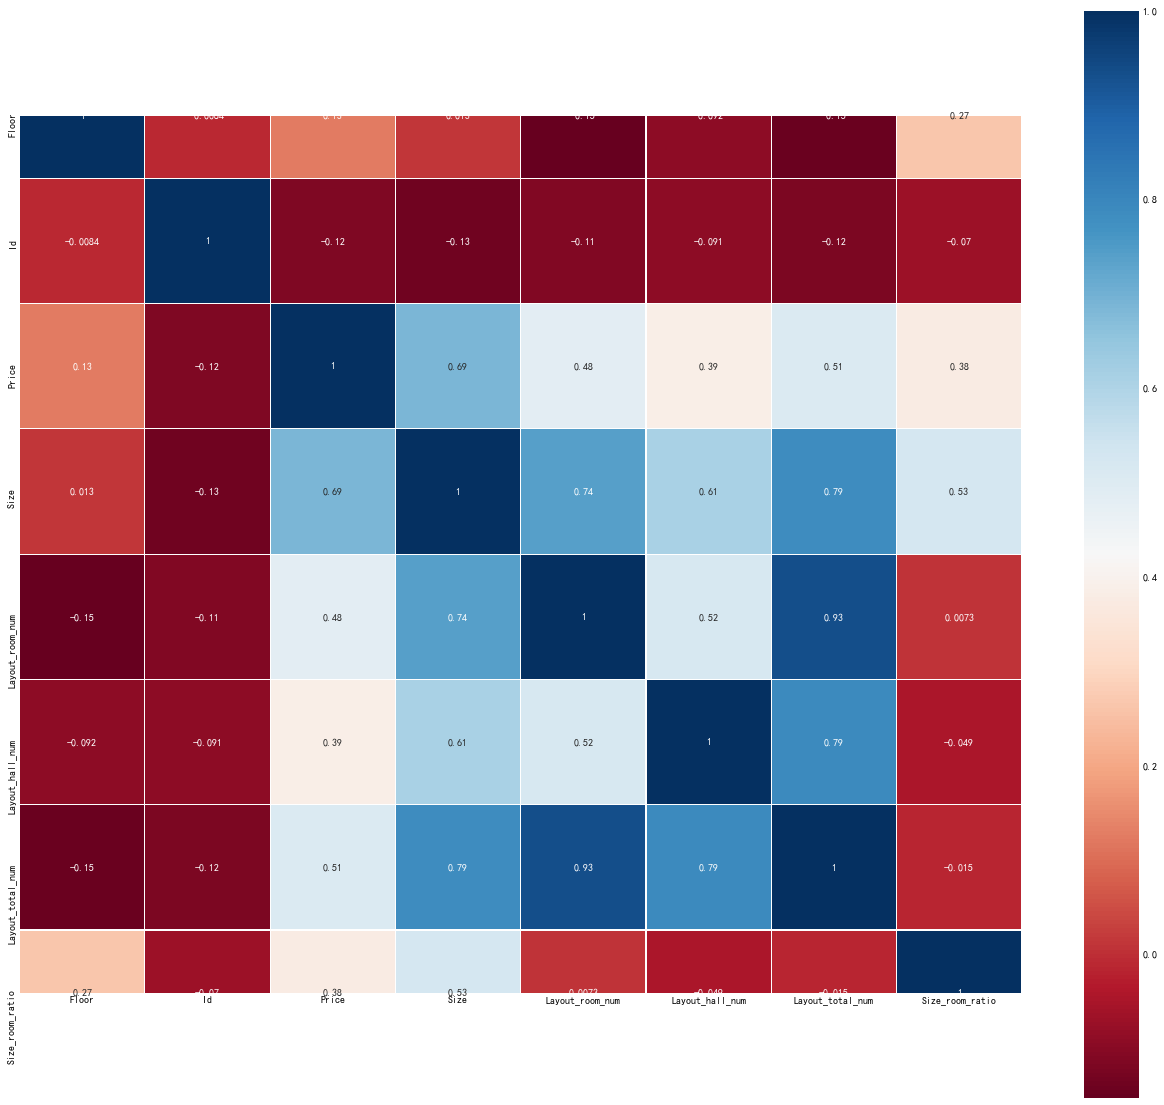

In [17]:
# 特征相关性

# data_corr 
colormap = plt.cm.RdBu
plt.figure(figsize=(20,20))
# plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [22]:
# 数据划分


# 特征变量和目标变量
features = df.drop('Price', axis=1)
prices = df['Price']
# 转换训练测试集格式为数组
features = np.array(features)
prices = np.array(prices)

# 导入sklearn进行训练测试集划分
from sklearn.model_selection import train_test_split
features_train, features_test, prices_train, prices_test = train_test_split(features, prices, test_size=0.2, random_state=0)

# 建立模型

In [25]:
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# 利用GridSearchCV计算最优解
def fit_model(X, y):
    """ 基于输入数据 [X,y]，利于网格搜索找到最优的决策树模型"""
    
    cross_validator = KFold(10, shuffle=True)
    regressor = DecisionTreeRegressor()
    
    params = {'max_depth':[1,2,3,4,5,6,7,8,9,10]}
    scoring_fnc = make_scorer(performance_metric)
    grid = GridSearchCV(estimator = regressor, param_grid = params, scoring = scoring_fnc, cv = cross_validator)

    # 基于输入数据 [X,y]，进行网格搜索
    grid = grid.fit(X, y)
#     print pd.DataFrame(grid.cv_results_)
    return grid.best_estimator_

# 计算R2分数
def performance_metric(y_true, y_predict):
    """计算并返回预测值相比于预测值的分数"""
    from sklearn.metrics import r2_score
    score = r2_score(y_true, y_predict)

    return score